In [3]:
# the sourse of code go from https://www.quantopian.com/posts/machine-learning-on-quantopian

# import libraries
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [4]:
#definition of factors
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest   
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        #'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors
factors = make_factors()

In [5]:
universe = Q500US() # Define universe and select factors to use
n_fwd_days = 5 # number of days to compute returns over

Differently to source I changed rank to zscore!  

In [6]:
# Define and build the pipeline
def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    factor_zscore = {name: f().zscore(mask=universe) for name, f in factors.iteritems()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_zscore['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    # Add many returns as factors
    for i in [2,3,4,5,7,10,20,60,100,250]:
        factor_zscore ['Return'+str(i)] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=i)    
    
    #factor_zscore['SPY']=Returns(inputs=[USEquityPricing.open('SPY')] )
    
    pipe = Pipeline(screen=universe, columns=factor_zscore)
    
    return pipe
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

In [7]:
# Because of problem with  time when taken a lot of data divide time to periods
end_full = pd.Timestamp("2016-08-07")
period = pd.DateOffset(100)
number_of_periods = 1
results=pd.DataFrame()
start = end_full-number_of_periods*(period)-(number_of_periods-1)*pd.DateOffset(1)

In [8]:
# Run pipeline
start_timer = time()
while end_full>start:
    print 'start', start ,'end' ,start+period
    results_period = run_pipeline(history_pipe, start_date=start, end_date=start+period)
    start+=(period+pd.DateOffset(1))
    results_period.index.names = ['date', 'security']
    results=pd.concat([results,results_period])
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

start 2016-04-29 00:00:00 end 2016-08-07 00:00:00


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Time to run pipeline 47.35 secs


In [9]:
results.head()

39 Week Returns  Asset Growth 3M  \
date                      security                                              
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])          0.061271        -0.130567   
                          Equity(24 [AAPL])        -0.820415         0.210220   
                          Equity(62 [ABT])         -0.507379        -0.172757   
                          Equity(67 [ADSK])         0.824003         0.324926   
                          Equity(76 [TAP])          1.733764        -0.302432   

                                             Asset to Equity Ratio  \
date                      security                                   
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])                0.028741   
                          Equity(24 [AAPL])               0.011032   
                          Equity(62 [ABT])                0.001126   
                          Equity(67 [ADSK])               0.037715   
                          Equity(76 [TAP])               -0.003923   

                                             Capex to Cashflows  \
date                      security                                
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])            -0.103404   
                          Equity(24 [AAPL])           -0.040244   
                          Equity(62 [ABT])            -0.055808   
                          Equity(67 [ADSK])           -0.032506   
                          Equity(76 [TAP])            -0.052330   

                                             EBIT to Assets  EBITDA Yield  \
date                      security                                          
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])        -0.703530     -0.736978   
                          Equity(24 [AAPL])        0.676811      2.998360   
                          Equity(62 [ABT])        -0.060126      0.032285   
                          Equity(67 [ADSK])       -0.381991     -0.271641   
                          Equity(76 [TAP])        -0.191842     -0.249007   

                                             MACD Signal Line  \
date                      security                              
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])          -0.361856   
                          Equity(24 [AAPL])         -0.233330   
                          Equity(62 [ABT])          -0.044943   
                          Equity(67 [ADSK])          0.167925   
                          Equity(76 [TAP])           0.087288   

                                             Mean Reversion 1M  \
date                      security                               
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])            1.130081   
                          Equity(24 [AAPL])          -2.006207   
                          Equity(62 [ABT])           -0.543807   
                          Equity(67 [ADSK])           0.189219   
                          Equity(76 [TAP])           -0.554174   

                                             Moneyflow Volume 5D  \
date                      security                                 
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])              0.143532   
                          Equity(24 [AAPL])            -2.589942   
                          Equity(62 [ABT])             -2.894180   
                          Equity(67 [ADSK])             0.841506   
                          Equity(76 [TAP])             -2.257662   

                                             Net Income Margin  \
date                      security                               
2016-04-29 00:00:00+00:00 Equity(2 [ARNC])           -0.062222   
                          Equity(24 [AAPL])           0.160915   
                          Equity(62 [ABT])            0.068194   
                          Equity(67 [ADSK])          -0.010781   
                          Equity(76 [TAP])            0.051474   

                                                       ...              \
date                      security         

In [10]:
# Sometimes there are duplicated indexis
results = results[~results.index.duplicated(keep='first')]
# Massage data to be in the form expected by shift_mask_data()
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 1, )
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 0, )

# Train-test split
train_size_perc = 0.5
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

In [11]:
def shift_mask_data_absolut_return(X, Y, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    level=0.01
    upper_mask = (Y > level)
    lower_mask = (Y <= level)
    
    
    # Try to predict the price go up to level 
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] =  1
    Y_binary[lower_mask.flatten()] = 0

    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))
    
    return X, Y_binary

In [12]:
def shift_mask_data(X, Y, upper_percentile=60, lower_percentile=40, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 0
    Y_binary[lower_mask.flatten()] = 1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

In [13]:
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days, 
                                             lower_percentile=30,
                                             upper_percentile=70)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

print X_train_shift.shape, X_test_shift.shape
print Y_train_shift.shape, Y_test_shift.shape

(8683, 27) (11982, 27)
(8683,) (11982,)


In [14]:
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()
X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)
print X_train_trans.shape, X_test_trans.shape

(8683, 27) (11982, 27)


In [15]:
cls_metrics = {
            'accuracy': metrics.accuracy_score,
            'precision':metrics.precision_score,
            'recall': metrics.recall_score ,
            'f1':metrics.f1_score,  
                }
metric_colors = {
            'accuracy': 'r',
             'precision':'b',
            'recall': 'g' ,
            'f1':'orange',
            'time':'blue',
            'time_PCA':'black'
                }

In [16]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
depths =  np.array([1,2,3,5,6,7,15,10,40,50,100,200,300,500])
    
for depth in depths:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=depth,n_estimators=100) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print depth,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)
    


1 2 3 5 6 7 15 10 40 50 100 200 300 500


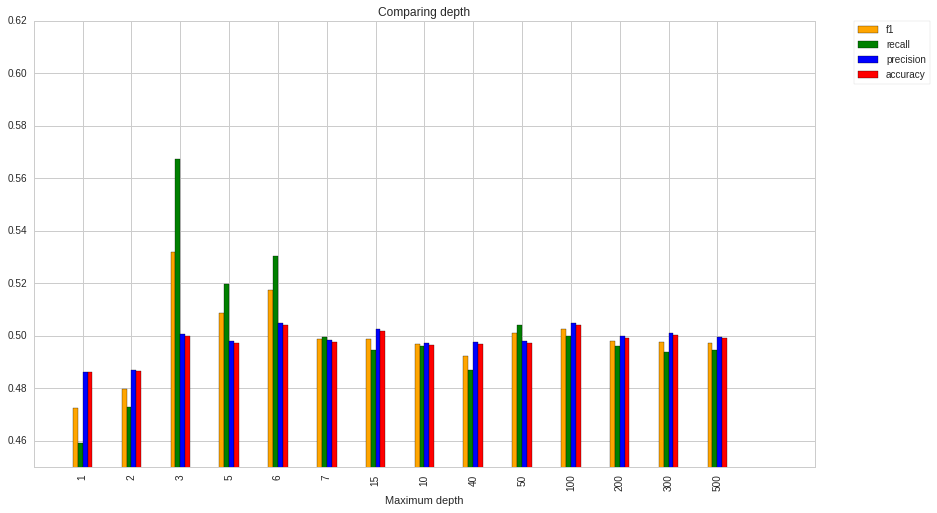

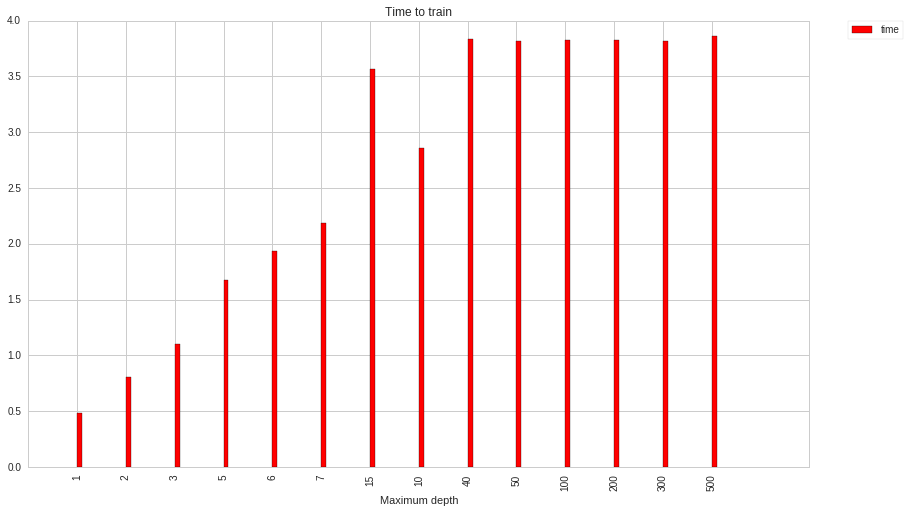

f1 for depth 3 max value 0.531916555981
recall for depth 3 max value 0.567333333333
precision for depth 100 max value 0.504880511612
accuracy for depth 6 max value 0.504172926056


In [17]:
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(depths)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing depth")
plt.xlabel('Maximum depth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(depths)+1)), depths, rotation='vertical')
plt.ylim((0.45,0.62))
plt.show()    

plt.bar(np.array(range(1,len(depths)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Maximum depth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(depths)+1)), depths, rotation='vertical')

plt.show()

for metric in cls_metrics:
    print metric, 'for depth', depths[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])

In [19]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
    
estimators =  np.array([10,20,30,35,40,45,50,70,100,200,300,400,500,])
    
for estimator in estimators:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=estimator) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print estimator,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)


10 20 30 35 40 45 50 70 100 200 300 400 500


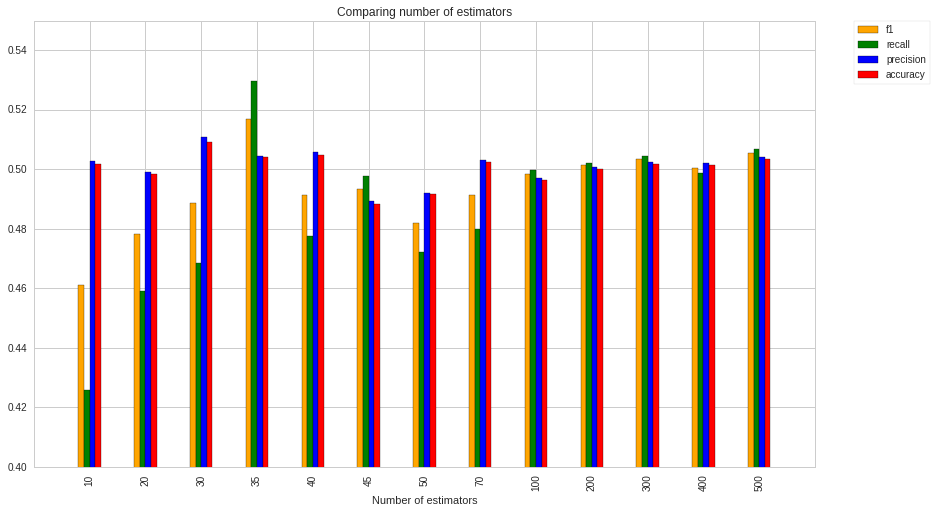

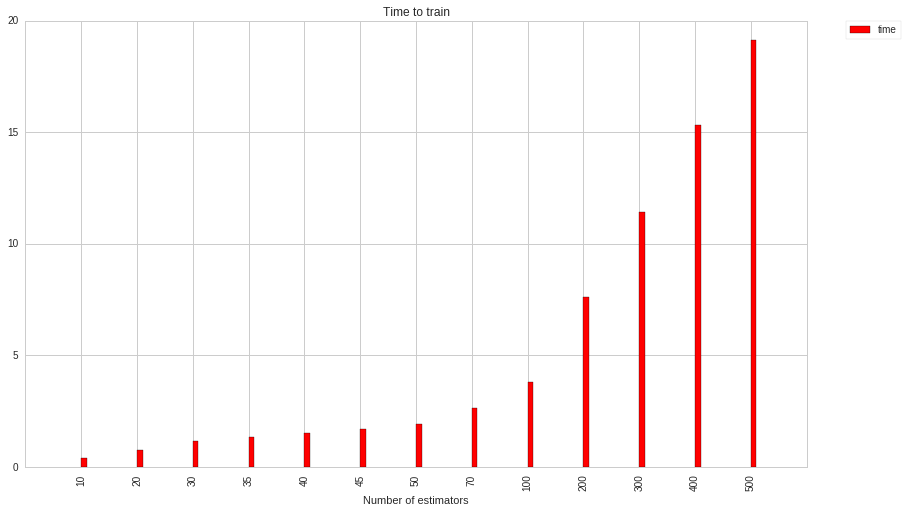

max f1 for variable 35 max value 0.516868547273
max recall for variable 35 max value 0.529833333333
max precision for variable 30 max value 0.510719476744
max accuracy for variable 30 max value 0.509096978802


In [26]:
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(estimators)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing number of estimators")
plt.xlabel('Number of estimators')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(estimators)+1)), estimators, rotation='vertical')
plt.ylim((0.4,0.55))
plt.show()    

plt.bar(np.array(range(1,len(estimators)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Number of estimators')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(estimators)+1)), estimators, rotation='vertical')
plt.show()

for metric in cls_metrics:
    print 'max', metric, 'for variable', estimators[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])

In [33]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]});
    
changed_variables =  np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
    
for changed_variable in changed_variables:
    start_timer = time()
    clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=30,max_features= changed_variable) 
    clf.fit(X_train_trans, Y_train_shift)
    
    Y_pred_test = clf.predict(X_test_trans)
    end_timer = time()
    print changed_variable,
    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
        metric_results_RF[metric].append(temp)
    
    metric_results_RF['time'].append(end_timer-start_timer)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18


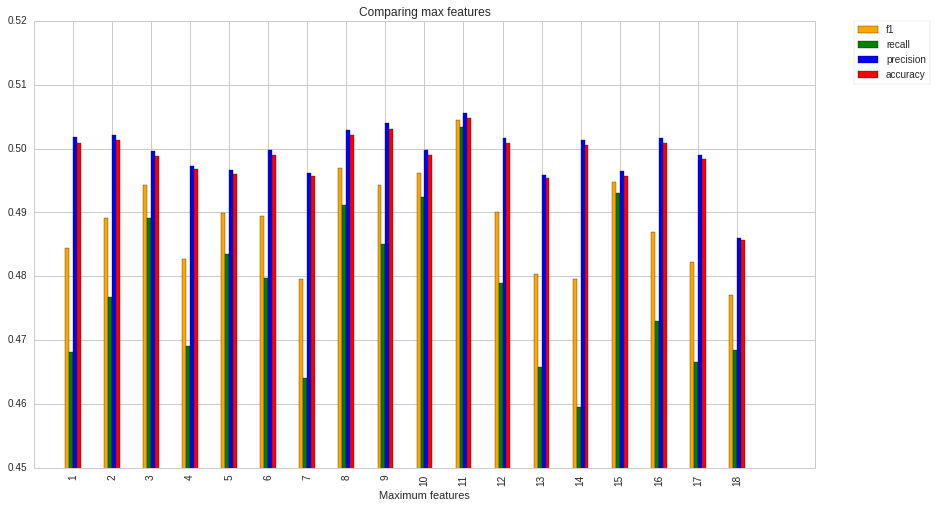

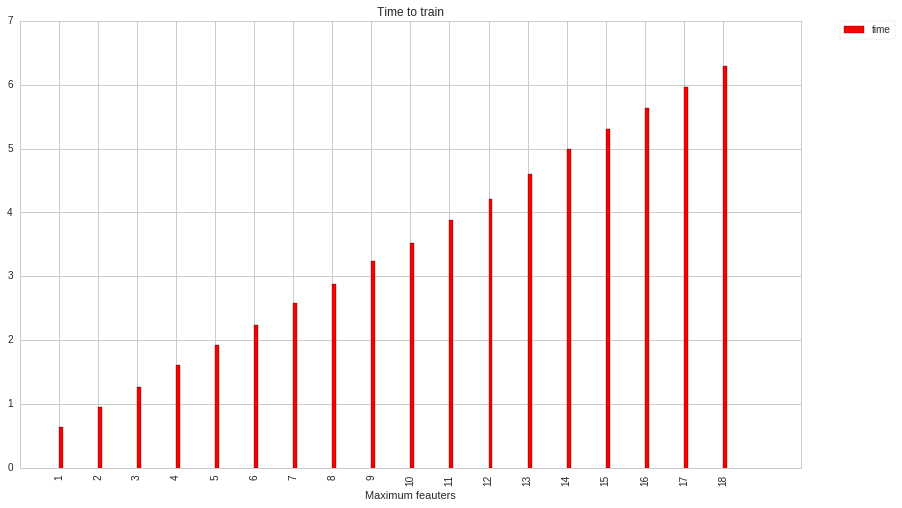

max f1 for max features 11 max value 0.504468387205
max recall for max features 11 max value 0.503333333333
max precision for max features 11 max value 0.505608571907
max accuracy for max features 11 max value 0.504840594225


In [32]:
mywidth = 0.1
shift = -(len(cls_metrics)-1)/2*mywidth

for metric in cls_metrics:
       
    plt.bar(np.array(range(1,len(changed_variables)+1))+shift, metric_results_RF[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   
plt.title("Comparing max features")
plt.xlabel('Maximum features')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(changed_variables)+1)), changed_variables, rotation='vertical')
plt.ylim((0.45,0.52))
plt.show()    

plt.bar(np.array(range(1,len(changed_variables)+1)), metric_results_RF['time'], width=mywidth,
        label = 'time', color=metric_colors[metric])
plt.title("Time to train")
plt.xlabel('Maximum feauters')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(np.array(range(1,len(changed_variables)+1)), changed_variables, rotation='vertical')
plt.show()

for metric in cls_metrics:
    print 'max', metric, 'for max features', changed_variables[np.argmax(metric_results_RF[metric])] \
    ,'max value', max(metric_results_RF[metric])

In [59]:
metric_results_RF={}
for metric in cls_metrics:
    metric_results_RF.update({metric:[]})
    metric_results_RF.update({'time':[]})
    metric_results_RF.update({'depth':[]})
    metric_results_RF.update({'estimator':[]})
    metric_results_RF.update({'feature':[]})
    
depths =  np.array([1,2,3,5,6,7,10,15,20,35,40,50,60,100,200])
features =  np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27])
estimators =  np.array([10,20,30,35,40,50,60,70,90,100,200,300,400])


for depth in depths:
    for feature in features:
        for estimator in estimators:  
            start_timer = time()
            clf = ensemble.RandomForestClassifier(max_depth=depth,n_estimators=estimator,max_features= feature) 
            clf.fit(X_train_trans, Y_train_shift)
            Y_pred_test = clf.predict(X_test_trans)
            end_timer = time()
            print 'depth',depth, 'feat', feature, 'est', estimator , \
            cls_metrics['precision'](Y_test_shift, Y_pred_test), end_timer-start_timer

            for metric in cls_metrics:         
                temp = cls_metrics[metric](Y_test_shift, Y_pred_test)
                metric_results_RF[metric].append(temp)

            metric_results_RF['time'].append(end_timer-start_timer)
            metric_results_RF['depth'].append(depth)
            metric_results_RF['estimator'].append(estimator)
            metric_results_RF['feature'].append(feature)

depth 1 est 10 feat 1 0.487387387387
depth 1 est 10 feat 2 0.493410543131
depth 1 est 10 feat 3 0.513831875781
depth 1 est 10 feat 4 0.4754330152
depth 1 est 10 feat 5 0.475106082037
depth 1 est 20 feat 1 0.488780657506
depth 1 est 20 feat 2 0.489337395278
depth 1 est 20 feat 3 0.468427835052
depth 1 est 20 feat 4 0.473607305936
depth 1 est 20 feat 5 0.500614574188
depth 1 est 30 feat 1 0.501414074197
depth 1 est 30 feat 2 0.4636148382
depth 1 est 30 feat 3 0.521317829457
depth 1 est 30 feat 4 0.465758034663
depth 1 est 30 feat 5 0.50858652576
depth 1 est 35 feat 1 0.517598994343
depth 1 est 35 feat 2 0.477408220897
depth 1 est 35 feat 3 0.489649272883
depth 1 est 35 feat 4 0.514992376758
depth 1 est 35 feat 5 0.491803278689
depth 1 est 40 feat 1 0.497166666667
depth 1 est 40 feat 2 0.464073300113
depth 1 est 40 feat 3 0.477065739361
depth 1 est 40 feat 4 0.457856567284
depth 1 est 40 feat 5 0.506164383562
depth 2 est 10 feat 1 0.511506110141
depth 2 est 10 feat 2 0.471170992669
depth 

In [58]:
for metric in cls_metrics:
    print 'max', metric, 'max value', max(metric_results_RF[metric]), 'for ' ,\
    'depth', metric_results_RF['depth'][np.argmax(metric_results_RF[metric])],\
    'estimator', metric_results_RF['estimator'][np.argmax(metric_results_RF[metric])],\
    'feature', metric_results_RF['feature'][np.argmax(metric_results_RF[metric])]
    
        
        
    

max f1 max value 0.550123530733 for  depth 1 estimator 30 feature 1
max recall max value 0.612333333333 for  depth 1 estimator 30 feature 1
max precision max value 0.53929807217 for  depth 1 estimator 10 feature 5
max accuracy max value 0.539058587882 for  depth 1 estimator 10 feature 5


In [42]:
metric_results_RF['depth'][10]

1

In [ ]:
metric_results_PCA={}
for metric in cls_metrics:
    metric_results_PCA.update({metric:[]});
    metric_results_PCA.update({'time':[]});
    metric_results_PCA.update({'time_PCA':[]});
pca_numbers = np.array(range(1,X.shape[2]+1))  
clf = ensemble.RandomForestClassifier(max_depth=30,n_estimators=50) 
    
for pca_number in pca_numbers :
    print pca_number,
    pca=decomposition.PCA(n_components = pca_number)
    start_timer_PCA=time()
    X_train_trans_PCA = pca.fit_transform(X_train_trans)
    X_test_trans_PCA = pca.transform(X_test_trans)
    end_timer_PCA=time()
    
    start_timer=time()
    clf.fit(X_train_trans_PCA, Y_train_shift)
    Y_pred_test_PCA    = clf.predict(X_test_trans_PCA)
    end_timer=time()

    
    for metric in cls_metrics:         
        temp = cls_metrics[metric](Y_test_shift, Y_pred_test_PCA)
        metric_results_PCA[metric].append(temp)
    
    metric_results_PCA['time'].append(end_timer-start_timer)
    metric_results_PCA['time_PCA'].append(end_timer_PCA-start_timer_PCA)



In [ ]:
mywidth =0.1  
shift=-(len(cls_metrics)-1)/2*mywidth
for metric in cls_metrics:
        
    plt.bar(pca_numbers+shift, metric_results_PCA[metric], width=mywidth,
        label = metric, color=metric_colors[metric])
    shift += mywidth
   

plt.title("Comparing numbers of components in PCA")
plt.xlabel('Numbers of components')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0.46,0.56))
plt.show()

plt.bar(np.array(range(1,len(pca_numbers)+1))-mywidth, metric_results_PCA['time'], width=mywidth,
        label = 'time to train RF', color='r')
plt.bar(np.array(range(1,len(pca_numbers)+1)), metric_results_PCA['time_PCA'], width=mywidth,
        label = 'time to train PCA', color='orange')

plt.title("Time to train")
plt.xlabel('Number of components')
plt.xticks(np.array(range(1,len(pca_numbers)+1)), pca_numbers, rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



for metric in cls_metrics:
    print 'max', metric, 'for number of components', pca_numbers[np.argmax(metric_results_PCA[metric])] \
    ,'max value', max(metric_results_PCA[metric])

In [ ]:
def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

In [ ]:
class ML(CustomFactor):
    init = False
    def compute(self, today, assets, out, returns, *inputs):
        # inputs is a list of factors, for example, assume we have 2 alpha signals, 3 stocks,
        # and a lookback of 2 days. Each element in the inputs list will be data of
        # one signal, so len(inputs) == 2. Then each element will contain a 2-D array
        # of shape [time x stocks]. For example:
        # inputs[0]:
        # [[1, 3, 2], # factor 1 rankings of day t-1 for 3 stocks  
        #  [3, 2, 1]] # factor 1 rankings of day t for 3 stocks
        # inputs[1]:
        # [[2, 3, 1], # factor 2 rankings of day t-1 for 3 stocks
        #  [1, 2, 3]] # factor 2 rankings of day t for 3 stocks
        
        if (not self.init) or (today.weekday == 0): # Monday
            # Instantiate sklearn objects
            self.imputer = imputer
            self.scaler = scaler
            self.clf = clf
        # Predict
        # Get most recent factor values (inputs always has the full history)
        last_factor_values = get_last_values(inputs)
        last_factor_values = self.imputer.transform(last_factor_values)
        last_factor_values = self.scaler.transform(last_factor_values)

        # Predict the probability for each stock going up 
        # (column 2 of the output of .predict_proba()) and
        # return it via assignment to out.
        out[:] = self.clf.predict_proba(last_factor_values)[:, 1]*100

In [ ]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe, window_length=5, n_fwd_days=2):
    factors_pipe = OrderedDict()
    # Create returns over last n days.
    factors_pipe['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    for i in [2,3,4,5,7,10,20,60,100,250]:
        factors_pipe ['Return'+str(i)] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=i)    
    # Instantiate ranked factors
    for name, f in factors.iteritems():
        factors_pipe[name] = f().zscore(mask=universe)
        
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    factors_pipe['ML'] = ML(inputs=factors_pipe.values(), 
                            window_length=window_length + 1, 
                            mask=universe)
    factors_pipe['ML_zscore']=factors_pipe['ML'].zscore(mask=universe)
    factors_pipe['ML_ranked']=factors_pipe['ML'].rank(mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

ml_pipe = make_ml_pipeline(factors, universe)

In [ ]:
start_timer = time()
start = pd.Timestamp("2016-08-07") # Can't choose a much longer time-period or we run out of RAM
end = pd.Timestamp("2017-08-07")

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

In [ ]:
results['ML_ranked']

In [ ]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")

In [ ]:
pricing.shape

In [ ]:
results.columns

In [ ]:
results.ML.iloc[1]

In [ ]:
results['Asset Growth 3M'].head()

In [ ]:
al.tears.create_factor_tear_sheet?

In [ ]:
al.tears.create_factor_tear_sheet(results['ML'], pricing, quantiles=2)